# Analyse Données

## setup

### Import des fichiers

In [2]:
#Temps et fichiers
import os
import warnings
import time
from datetime import timedelta

#Manipulation de données
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from functools import partial


#Modélisation
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import PoissonRegressor, GammaRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_tweedie_deviance
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, auc

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV# the keys can be accessed with final_pipeline.get_params().keys()
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

#Text
import re

#Evaluation
from sklearn.metrics import f1_score, confusion_matrix


#Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


#Tracking d'expérience
import mlflow
import mlflow.sklearn

### Utilisation du code du projet packagé

In [3]:
#Cette cellule permet d'appeler la version packagée du projet et d'en assurer le reload avant appel des fonctions
%load_ext autoreload
%autoreload 2

In [4]:
random_state=42

### Configuration de l'experiment MLFlow

In [5]:
mlflow.tracking.get_tracking_uri()

'/mnt/experiments'

## Chargement des données

In [229]:
# On Importe les données

#df
df_merged =pd.read_parquet('/mnt/data/interim/df_merged.gzip')
df_train=pd.read_parquet('/mnt/data/interim/df_train.gzip')
df_val=pd.read_parquet('/mnt/data/interim/df_val.gzip')

#X
X_train=pd.read_parquet('/mnt/data/interim/X_train.gzip')
X_val=pd.read_parquet('/mnt/data/interim/X_val.gzip')
X_test=pd.read_parquet('/mnt/data/interim/X_test.gzip')

#y
y_train=pd.read_parquet('/mnt/data/interim/y_train.gzip')
y_val=pd.read_parquet('/mnt/data/interim/y_val.gzip')

## Analyse

### Choix du fichier source et de la variable d'intérêt

In [232]:
data=df_train
titre='TRAIN'
field='COUT'

### Tout exécuter à partir de là

#### Temporelle

In [233]:
from hackathondsa_groupe4.viz.graphs import *

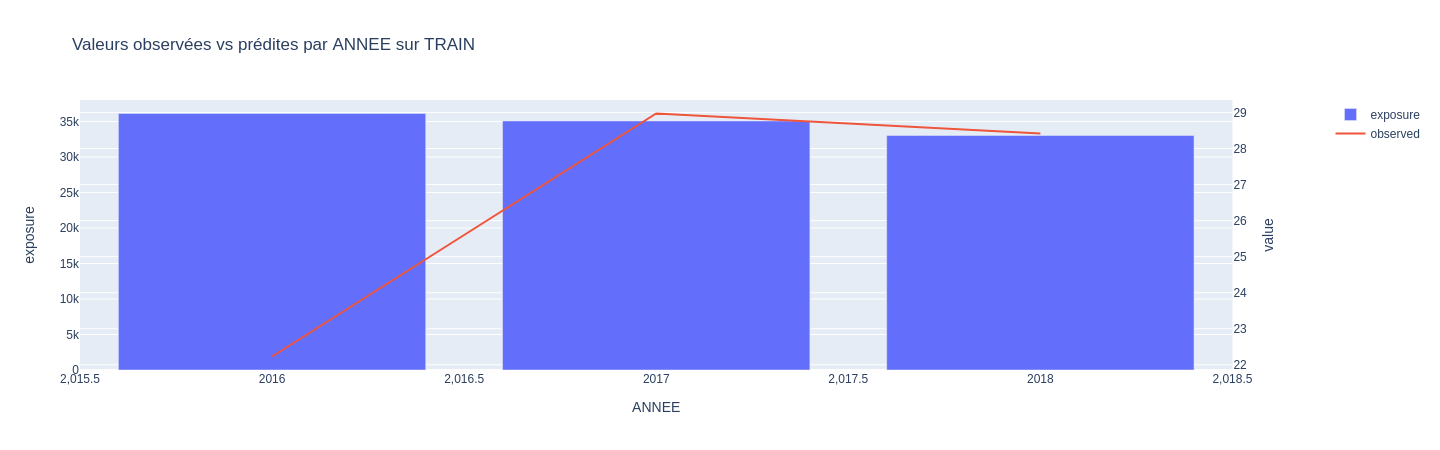

,ANNEE,EXPO,observed
0,2016,36138.450208,22.231013
1,2017,35085.162220,28.971577
2,2018,33043.291584,28.415943


In [234]:
plot_obs_pred_3(
    df=data,
    feature="ANNEE",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    title_train_test=titre,
    output_df=True
)

**INSIGHT** Il y a bien un effet d'inflation

- il faut redresser les données historiques avant analyse
- il faut anticiper un facteur d'inflation pour 

#### FORMULE

In [235]:
from hackathondsa_groupe4.viz.graphs import plot_obs_pred_3

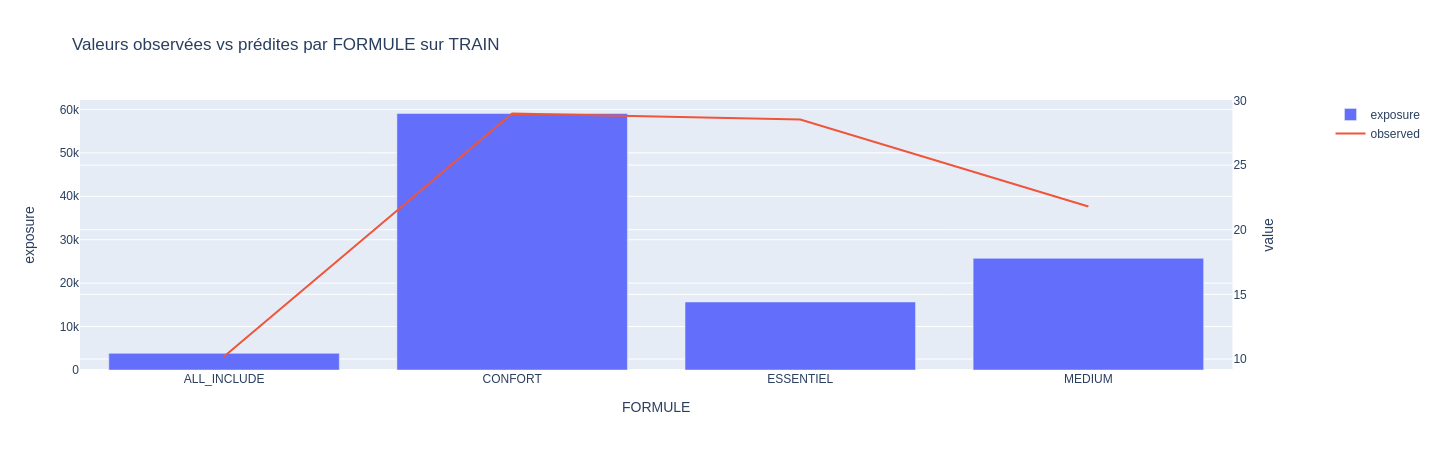

,FORMULE,EXPO,observed
0,ALL_INCLUDE,3830.057540,10.191391
1,CONFORT,59063.894972,28.994432
2,ESSENTIEL,15661.278609,28.527821
3,MEDIUM,25711.672891,21.798787


In [236]:
plot_obs_pred_3(
    df=data,
    feature="FORMULE",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    title_train_test=titre,
    output_df=True
)

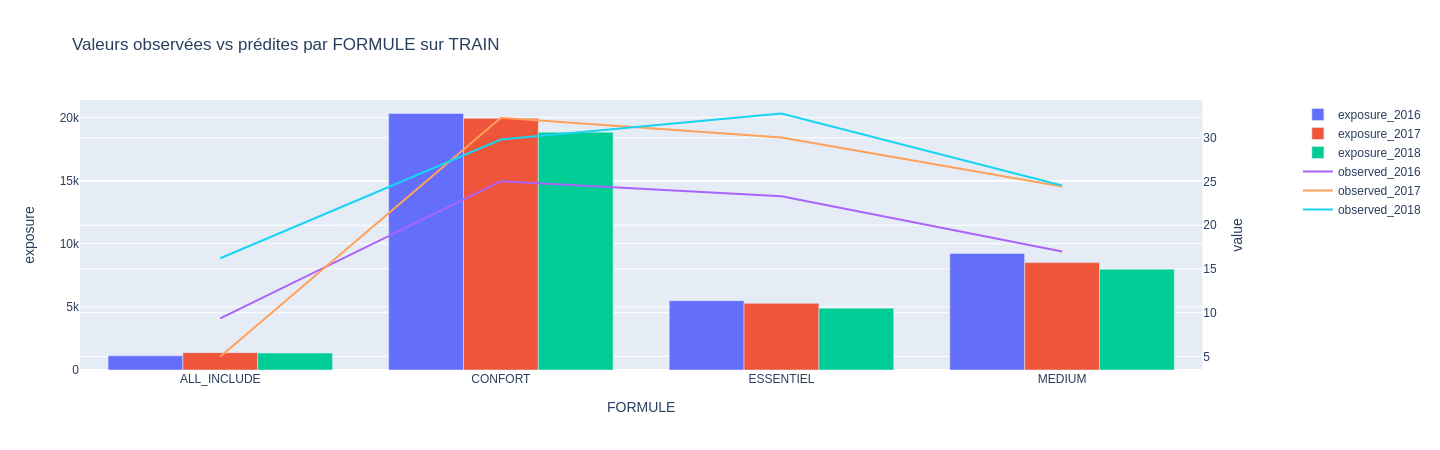

,FORMULE,ANNEE,EXPO,observed
0,ALL_INCLUDE,2016,1118.701245,9.343169
1,ALL_INCLUDE,2017,1371.860517,4.993562
2,ALL_INCLUDE,2018,1339.495778,16.223216
3,CONFORT,2016,20305.363393,25.030486
4,CONFORT,2017,19932.310532,32.277534
5,CONFORT,2018,18826.221048,29.793826
6,ESSENTIEL,2016,5483.580617,23.299284
7,ESSENTIEL,2017,5280.100903,30.023551
8,ESSENTIEL,2018,4897.597089,32.769392
9,MEDIUM,2016,9230.804953,17.000202


In [237]:
plot_obs_pred_3(
    df=data,
    feature="FORMULE",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test=titre,
    output_df=True
)

**INSIGHT** : une différence `ALL_INCLUSIVE` vs reste qui semble stable dans le temps

#### TYPE_RESIDENCE

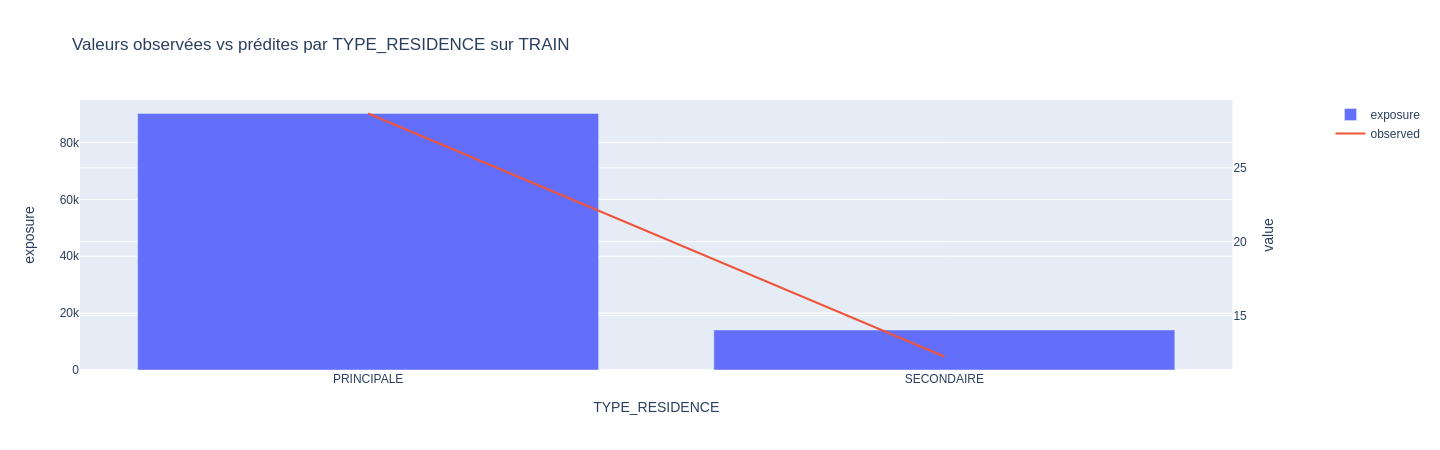

,TYPE_RESIDENCE,EXPO,observed
0,PRINCIPALE,90194.314782,28.679517
1,SECONDAIRE,14072.589231,12.229009


In [238]:
plot_obs_pred_3(
    df=data,
    feature="TYPE_RESIDENCE",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    title_train_test=titre,
    output_df=True
)

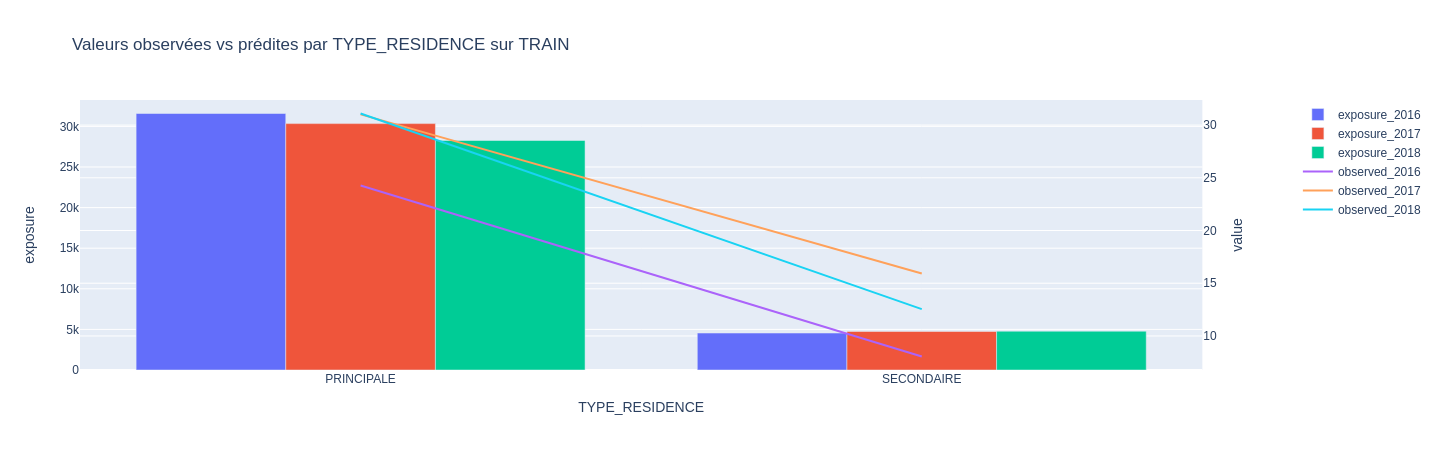

,TYPE_RESIDENCE,ANNEE,EXPO,observed
0,PRINCIPALE,2016,31588.519075,24.273576
1,PRINCIPALE,2017,30341.643470,31.012753
2,PRINCIPALE,2018,28264.152237,31.098938
3,SECONDAIRE,2016,4549.931133,8.050246
4,SECONDAIRE,2017,4743.518750,15.915312
5,SECONDAIRE,2018,4779.139347,12.548529


In [239]:
plot_obs_pred_3(
    df=data,
    feature="TYPE_RESIDENCE",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test=titre,
    output_df=True
)

**INSIGHT** : une différence `PRINCIPALE` vs reste qui semble stable dans le temps

#### TYPE_HABITATION

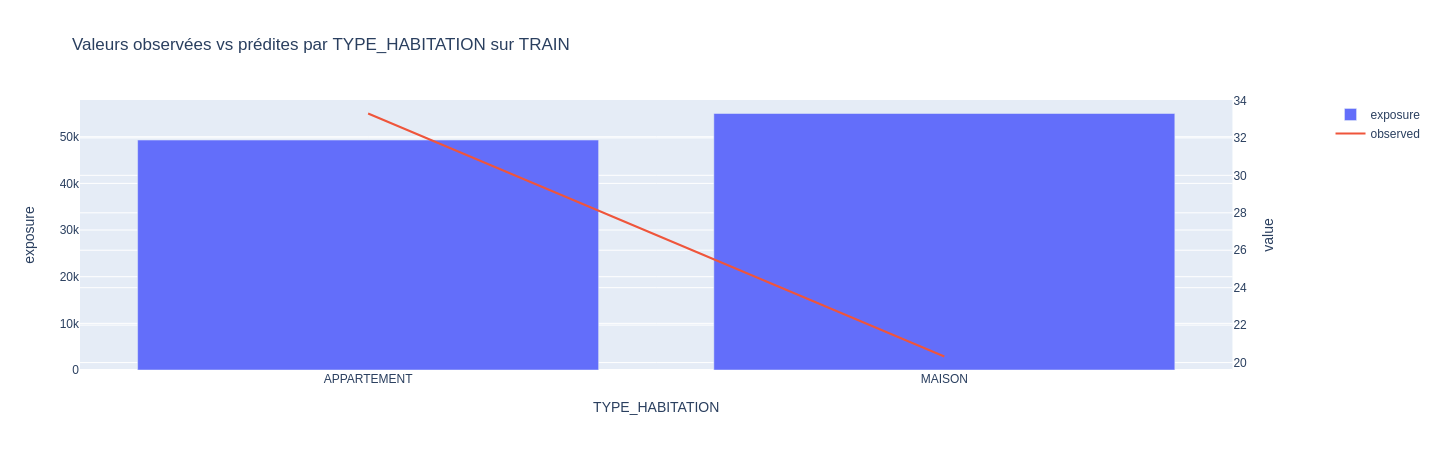

,TYPE_HABITATION,EXPO,observed
0,APPARTEMENT,49286.973246,33.302928
1,MAISON,54979.930767,20.324191


In [240]:
plot_obs_pred_3(
    df=data,
    feature="TYPE_HABITATION",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    title_train_test=titre,
    output_df=True
)

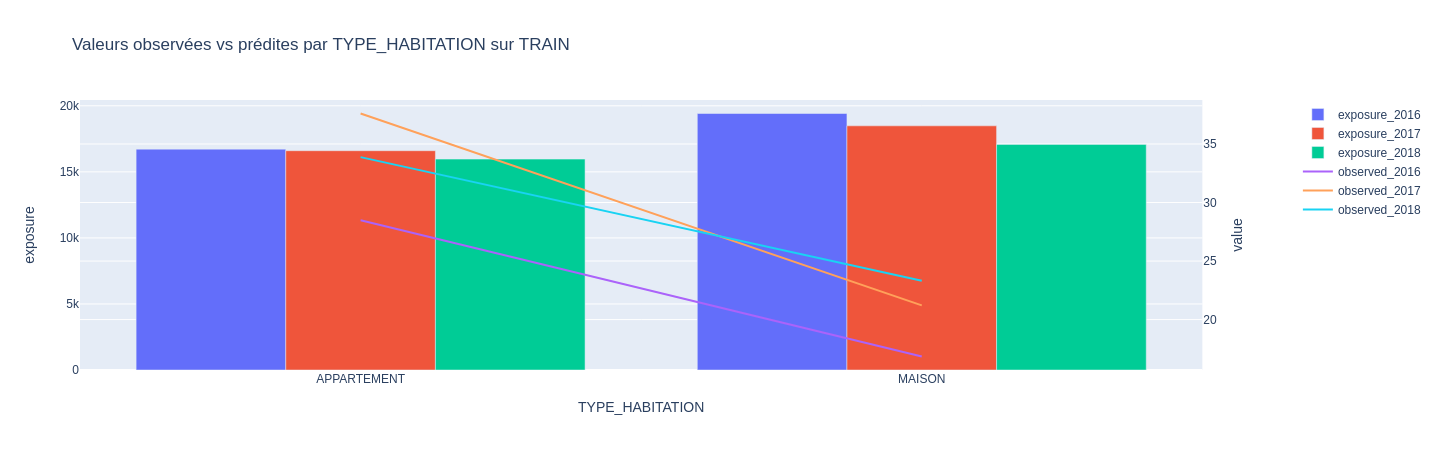

,TYPE_HABITATION,ANNEE,EXPO,observed
0,APPARTEMENT,2016,16720.591080,28.484602
1,APPARTEMENT,2017,16601.034847,37.604614
2,APPARTEMENT,2018,15965.347318,33.876221
3,MAISON,2016,19417.859128,16.846090
4,MAISON,2017,18484.127373,21.218041
5,MAISON,2018,17077.944266,23.311392


In [241]:
plot_obs_pred_3(
    df=data,
    feature="TYPE_HABITATION",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test=titre,
    output_df=True
)

#### NB_PIECES

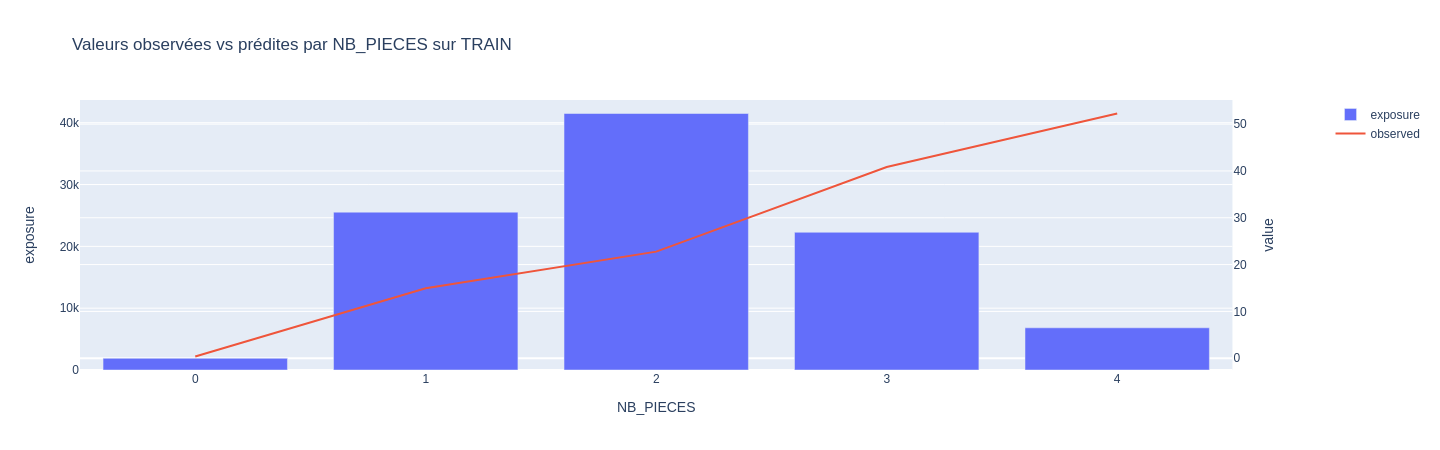

,NB_PIECES,EXPO,observed
0,0.0,1886.987758,0.368073
1,1.0,25533.020812,14.929807
2,2.0,41491.079246,22.765626
3,3.0,22277.479593,40.837571
4,4.0,6826.708875,52.273699


In [242]:
plot_obs_pred_3(
    df=data,
    feature="NB_PIECES",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    title_train_test=titre,
    output_df=True
)

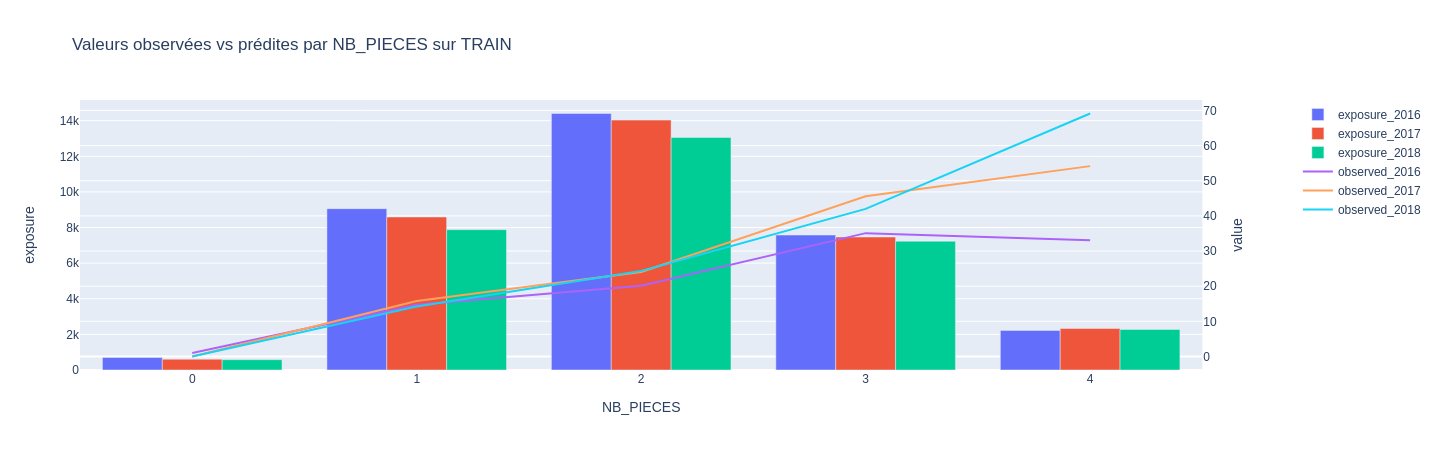

,NB_PIECES,ANNEE,EXPO,observed
0,0.0,2016,701.019093,0.990770
1,0.0,2017,606.387908,0.000000
2,0.0,2018,579.580757,0.000000
3,1.0,2016,9060.451464,14.734793
4,1.0,2017,8590.813669,15.770252
5,1.0,2018,7881.755679,14.237931
6,2.0,2016,14403.147249,20.151582
7,2.0,2017,14031.379148,24.021833
8,2.0,2018,13056.552850,24.299273
9,3.0,2016,7578.287388,35.091321


In [243]:
plot_obs_pred_3(
    df=data,
    feature="NB_PIECES",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test=titre,
    output_df=True
)

**INSIGHT** : une différence `0` vs `1-2` vs `3` vs `4` stable

#### SITUATION_JURIDIQUE

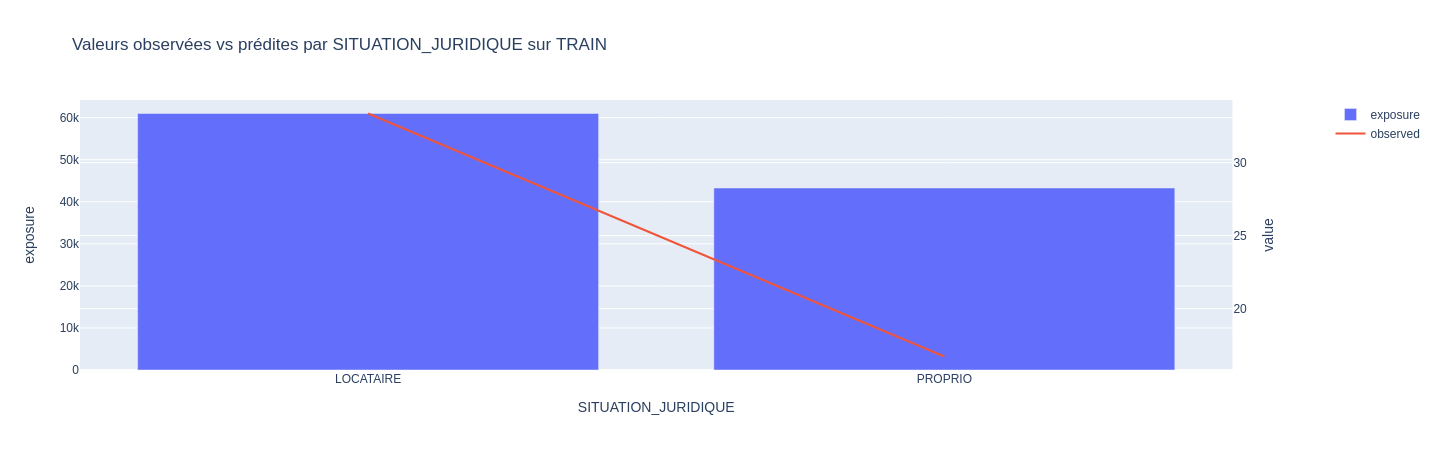

,SITUATION_JURIDIQUE,EXPO,observed
0,LOCATAIRE,60992.664372,33.369215
1,PROPRIO,43274.239641,16.720013


In [244]:
plot_obs_pred_3(
    df=data,
    feature="SITUATION_JURIDIQUE",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    title_train_test=titre,
    output_df=True
)

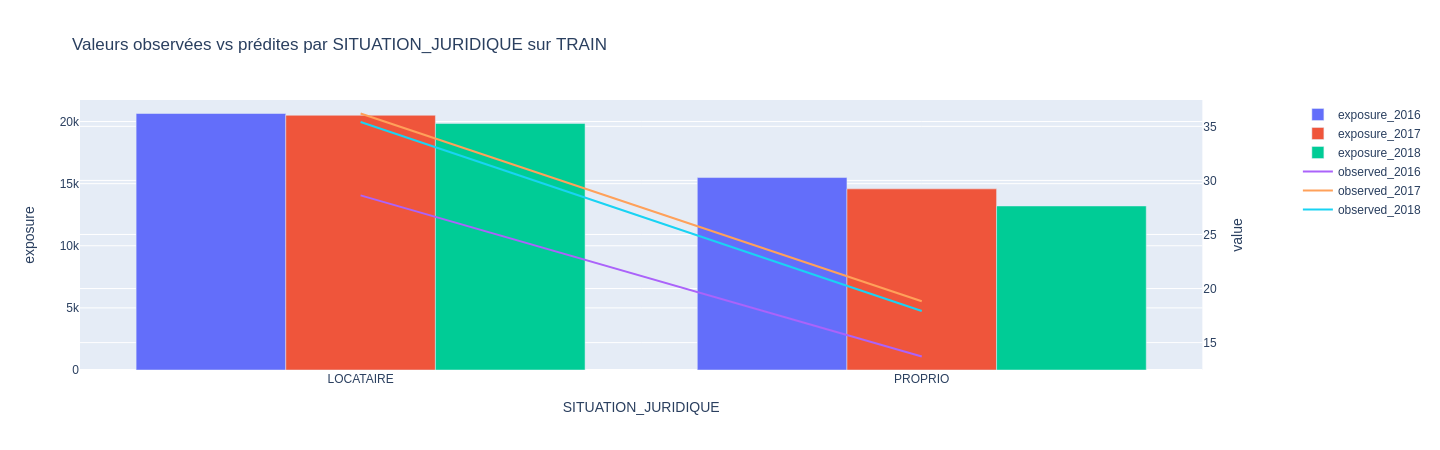

,SITUATION_JURIDIQUE,ANNEE,EXPO,observed
0,LOCATAIRE,2016,20647.574591,28.620074
1,LOCATAIRE,2017,20504.709657,36.188878
2,LOCATAIRE,2018,19840.380124,35.397496
3,PROPRIO,2016,15490.875617,13.715123
4,PROPRIO,2017,14580.452563,18.821779
5,PROPRIO,2018,13202.911461,17.924571


In [245]:
plot_obs_pred_3(
    df=data,
    feature="SITUATION_JURIDIQUE",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test=titre,
    output_df=True
)

**INSIGHT** : une différence `LOCATAIRE` vs `PROPRIETAIRE`  stable

#### NIVEAU_JURIDIQUE

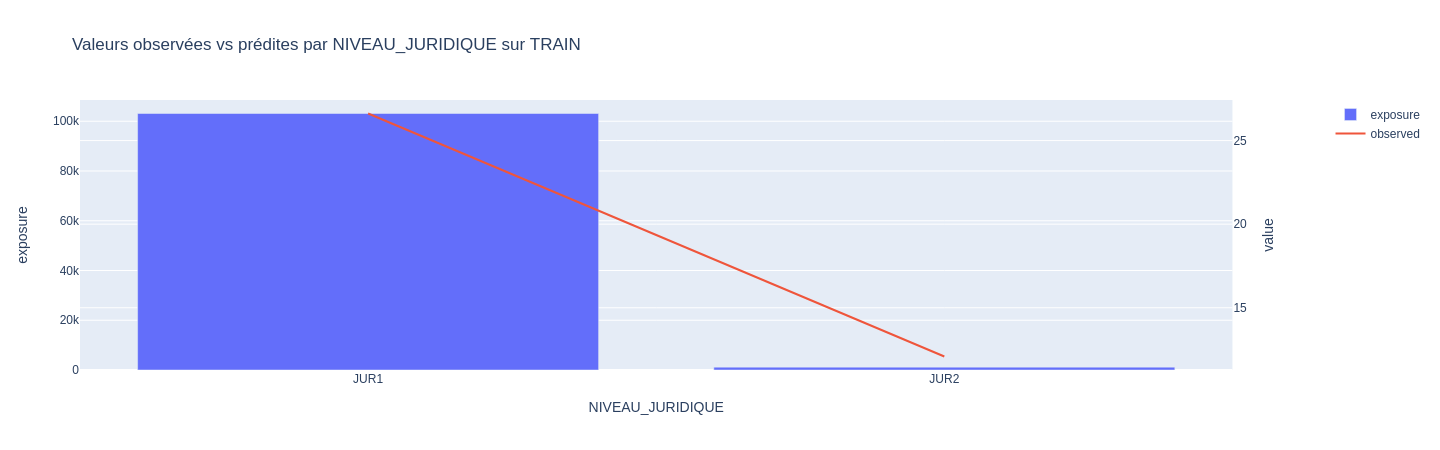

,NIVEAU_JURIDIQUE,EXPO,observed
0,JUR1,103116.973198,26.619536
1,JUR2,1149.930815,12.085214


In [246]:
plot_obs_pred_3(
    df=data,
    feature="NIVEAU_JURIDIQUE",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    title_train_test=titre,
    output_df=True
)

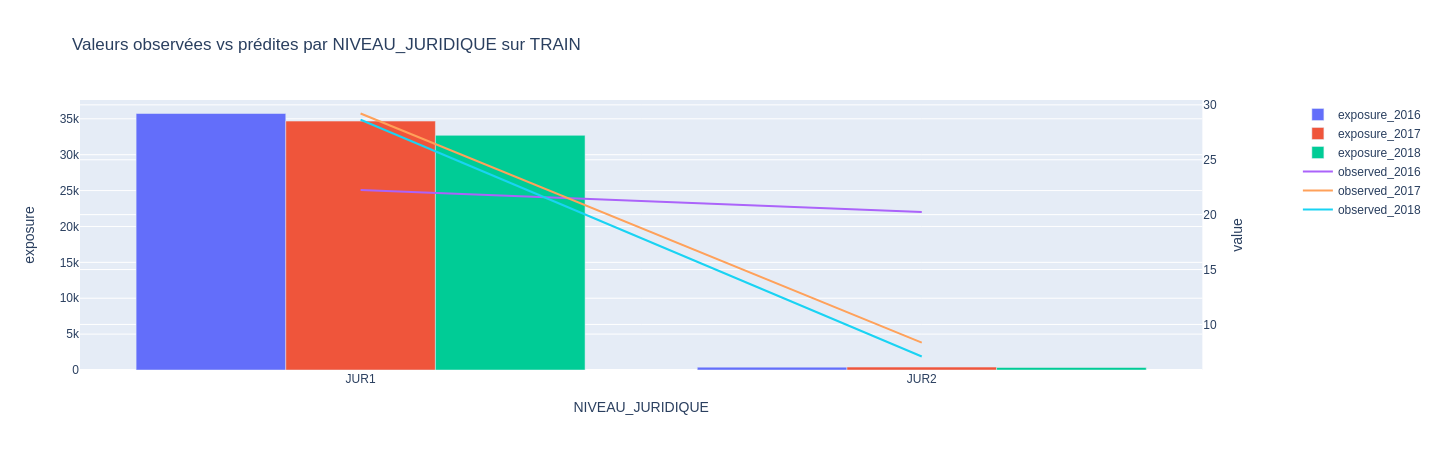

,NIVEAU_JURIDIQUE,ANNEE,EXPO,observed
0,JUR1,2016,35740.313256,22.253124
1,JUR1,2017,34680.949143,29.211916
2,JUR1,2018,32695.710799,28.642760
3,JUR2,2016,398.136952,20.246204
4,JUR2,2017,404.213078,8.350810
5,JUR2,2018,347.580785,7.080055


In [247]:
plot_obs_pred_3(
    df=data,
    feature="NIVEAU_JURIDIQUE",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test=titre,
    output_df=True
)

**INSIGHT** : A ABANDONNER NON STABLE

#### VALEUR_DES_BIENS

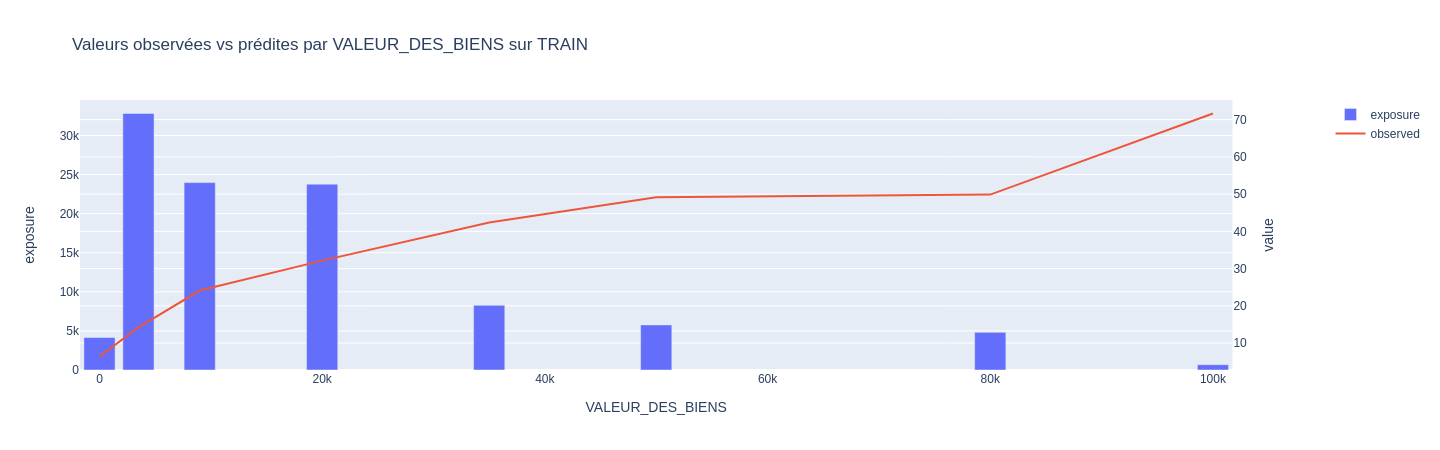

,VALEUR_DES_BIENS,EXPO,observed
0,0.0,4155.078598,6.395528
1,3500.0,32815.602862,14.213807
2,9000.0,23972.341397,24.106043
3,20000.0,23776.433502,32.142123
4,35000.0,8274.876021,42.404247
5,50000.0,5771.545119,49.140021
6,80000.0,4817.108528,49.865394
7,100000.0,683.917986,71.646762


In [248]:
plot_obs_pred_3(
    df=data,
    feature="VALEUR_DES_BIENS",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    title_train_test=titre,
    output_df=True
)

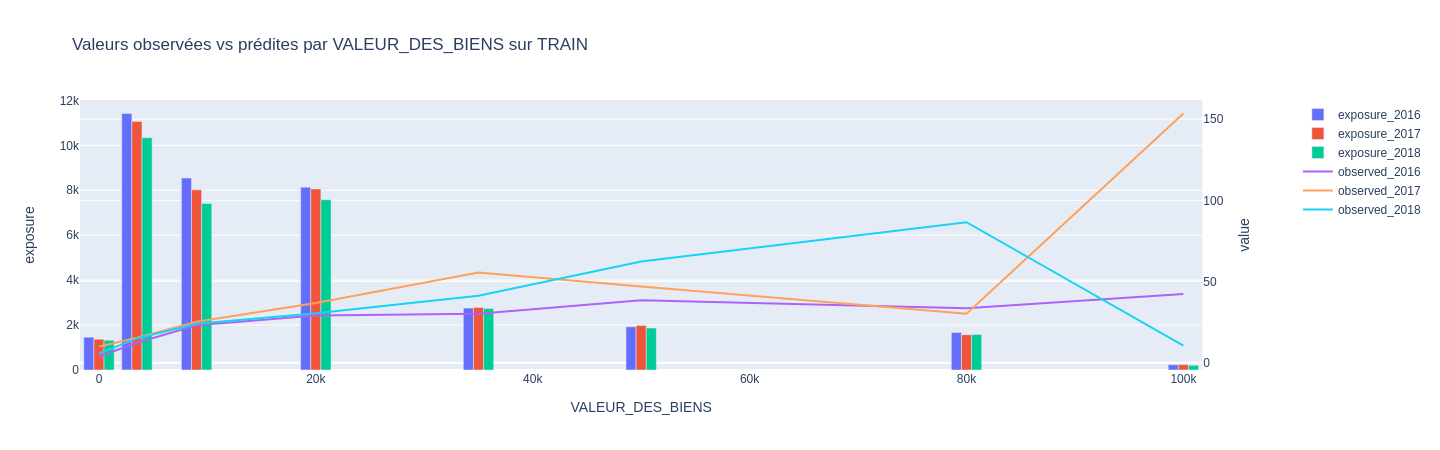

,VALEUR_DES_BIENS,ANNEE,EXPO,observed
0,0.0,2016,1462.764213,3.838247
1,0.0,2017,1369.147398,9.804269
2,0.0,2018,1323.166987,5.695411
3,3500.0,2016,11416.344422,12.314970
4,3500.0,2017,11059.157733,15.474420
5,3500.0,2018,10340.100707,14.962006
6,9000.0,2016,8541.462628,23.120783
7,9000.0,2017,8020.013314,25.291034
8,9000.0,2018,7410.865454,23.959221
9,20000.0,2016,8138.462707,29.038554


In [249]:
plot_obs_pred_3(
    df=data,
    feature="VALEUR_DES_BIENS",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test=titre,
    output_df=True
)

**INSIGHT** : il y a bien un impact croissant (surpenant) en NB an vfonction de la valeur des biens (ordinal)

**=>** Ordinal encoding

#### OBJETS_DE_VALEUR

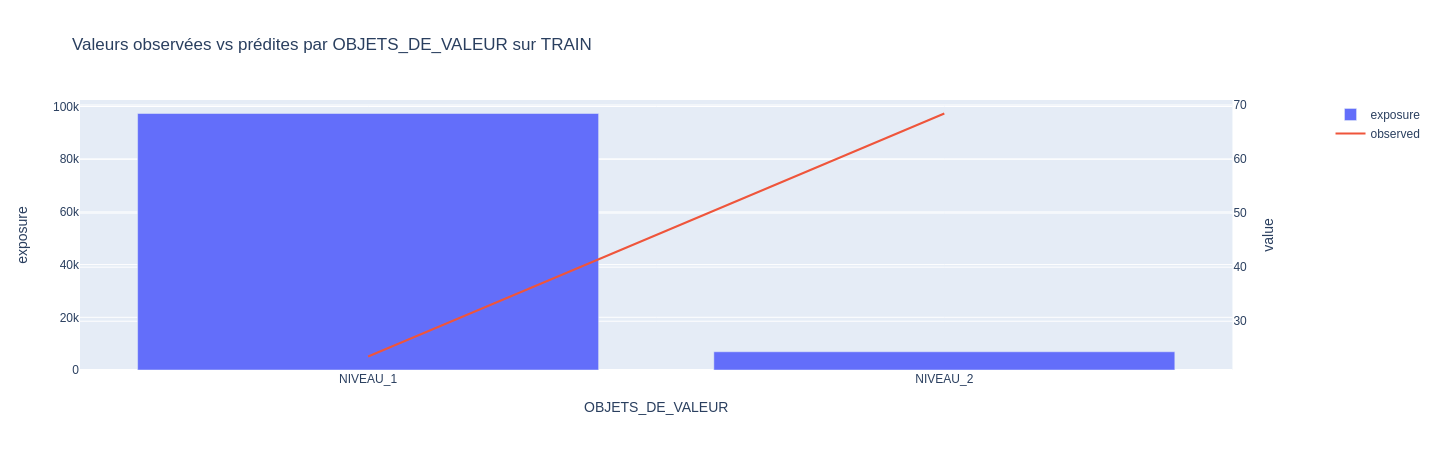

,OBJETS_DE_VALEUR,EXPO,observed
0,NIVEAU_1,97348.428915,23.476809
1,NIVEAU_2,6918.475097,68.424425


In [250]:
plot_obs_pred_3(
    df=data,
    feature="OBJETS_DE_VALEUR",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    title_train_test=titre,
    output_df=True
)

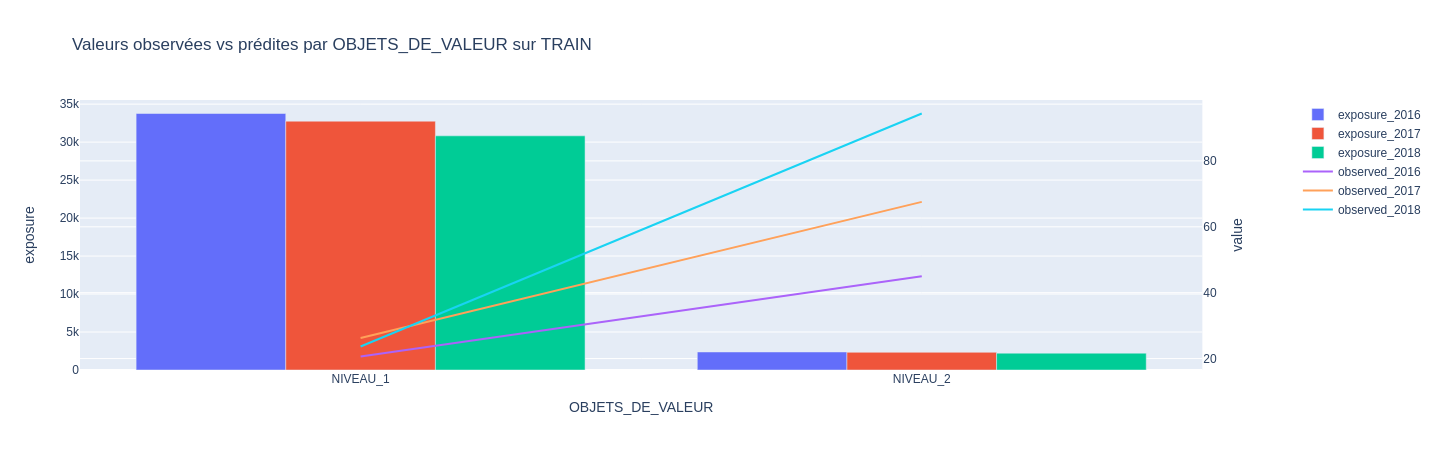

,OBJETS_DE_VALEUR,ANNEE,EXPO,observed
0,NIVEAU_1,2016,33766.762623,20.631468
1,NIVEAU_1,2017,32755.662301,26.227221
2,NIVEAU_1,2018,30826.003991,23.671008
3,NIVEAU_2,2016,2371.687585,45.004442
4,NIVEAU_2,2017,2329.499919,67.560640
5,NIVEAU_2,2018,2217.287593,94.382750


In [251]:
plot_obs_pred_3(
    df=data,
    feature="OBJETS_DE_VALEUR",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test=titre,
    output_df=True
)

**INSIGHT** : il y a bien un effet

#### ZONIER

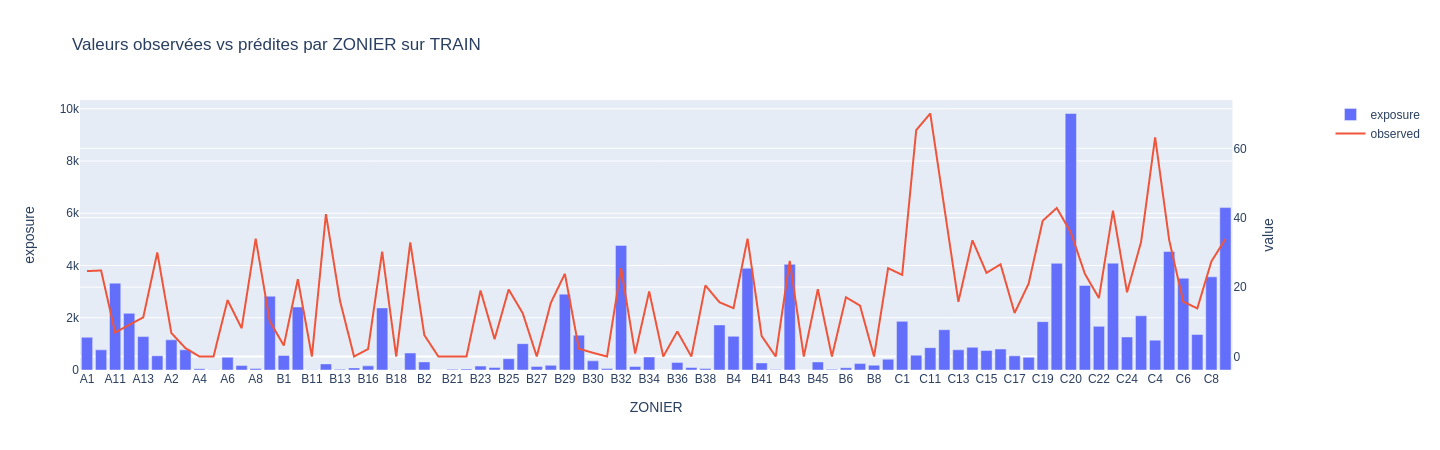

,ZONIER,EXPO,observed
0,A1,1252.319122,24.610325
1,A10,770.556474,24.801076
2,A11,3325.739537,6.924648
3,A12,2169.655434,9.080053
4,A13,1279.302851,11.279380
...,...,...,...
77,C5,4535.278735,33.542044
78,C6,3514.730014,15.800941
79,C7,1359.184596,13.869977
80,C8,3566.794293,27.381861


In [252]:
plot_obs_pred_3(
    df=data,
    feature="ZONIER",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    title_train_test=titre,
    output_df=True
)

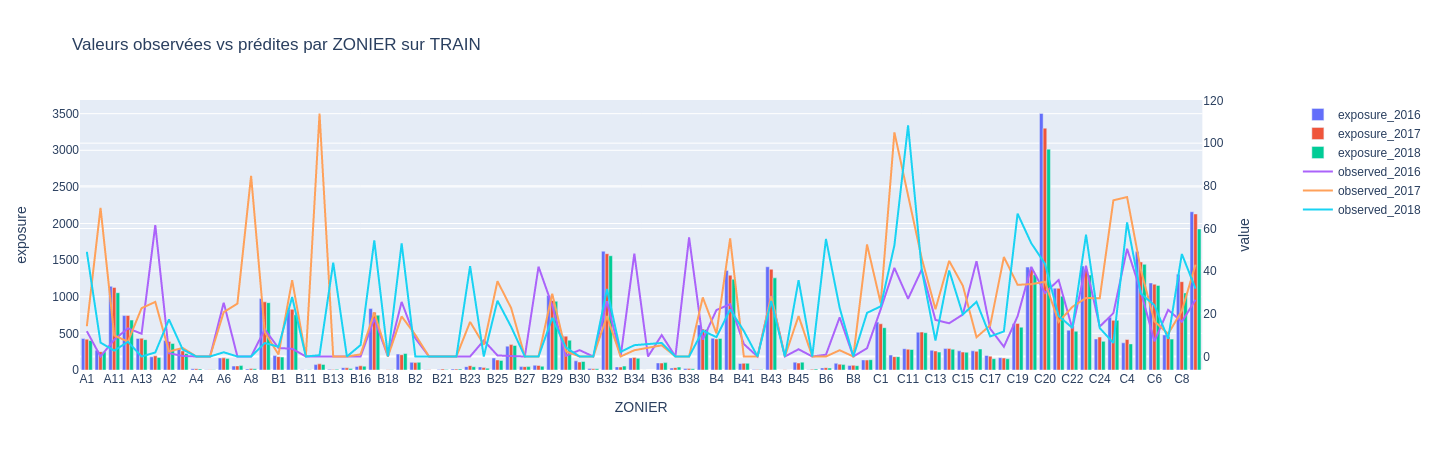

,ZONIER,ANNEE,EXPO,observed
0,A1,2016,429.399979,11.873327
1,A1,2017,420.499982,14.195476
2,A1,2018,402.419161,49.084088
3,A10,2016,270.117794,0.000000
4,A10,2017,250.874305,69.699286
...,...,...,...,...
238,C8,2017,1206.005396,21.404241
239,C8,2018,1051.802674,48.065245
240,C9,2016,2160.586177,26.573823
241,C9,2017,2130.988960,43.053608


In [253]:
plot_obs_pred_3(
    df=data,
    feature="ZONIER",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test=titre,
    output_df=True
)

**INSIGHT** : N'a pas l'air stable, on a surtout de l'exposition en C

#### NBSIN_TYPE1_AN1

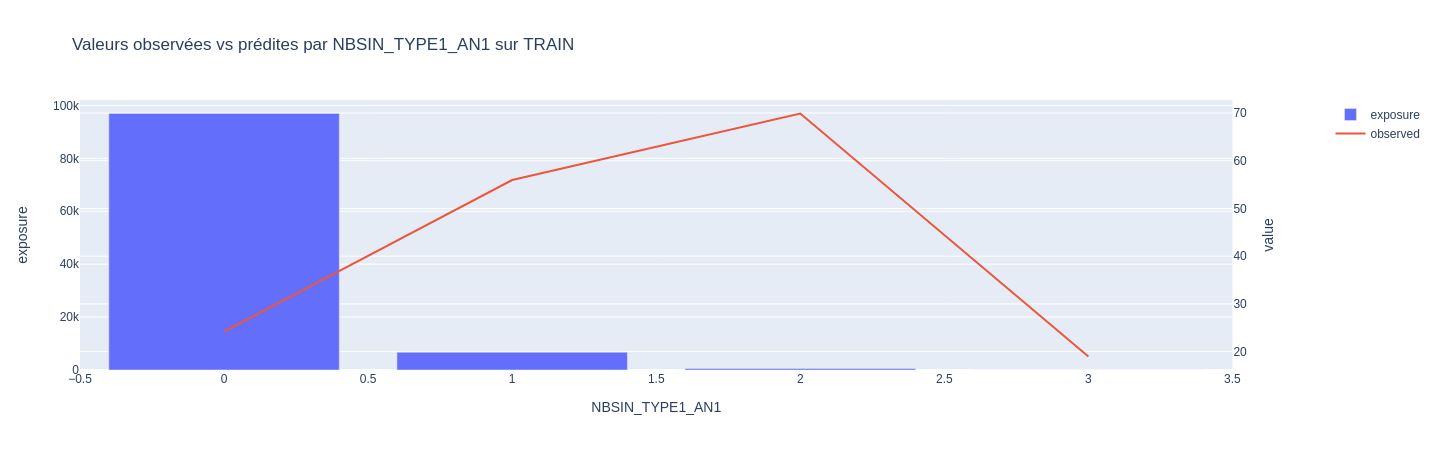

,NBSIN_TYPE1_AN1,EXPO,observed
0,0,96947.995215,24.168570
1,1,6715.934925,55.968092
2,2,557.787148,69.907399
3,3,45.186725,18.971501


In [254]:
plot_obs_pred_3(
    df=data,
    feature="NBSIN_TYPE1_AN1",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    title_train_test=titre,
    output_df=True
)

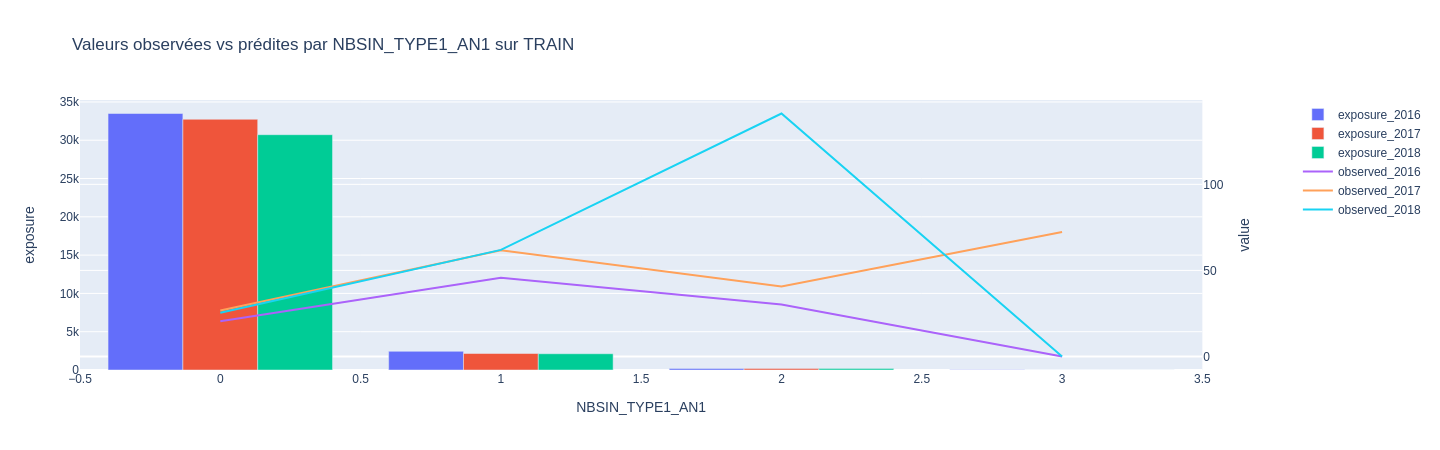

,NBSIN_TYPE1_AN1,ANNEE,EXPO,observed
0,0,2016,33490.083159,20.482607
1,0,2017,32734.957382,26.739692
2,0,2018,30722.954674,25.447015
3,1,2016,2438.808152,45.780715
4,1,2017,2154.677524,61.641058
5,1,2018,2122.449248,61.914827
6,2,2016,191.767118,30.139507
7,2,2017,183.683053,40.700282
8,2,2018,182.336978,141.154746
9,3,2016,17.791779,0.000000


In [255]:
plot_obs_pred_3(
    df=data,
    feature="NBSIN_TYPE1_AN1",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test=titre,
    output_df=True
)

**INSIGHT** : Puet être un petit effet `0` vs `1+`

#### NBSIN_TYPE1_AN3

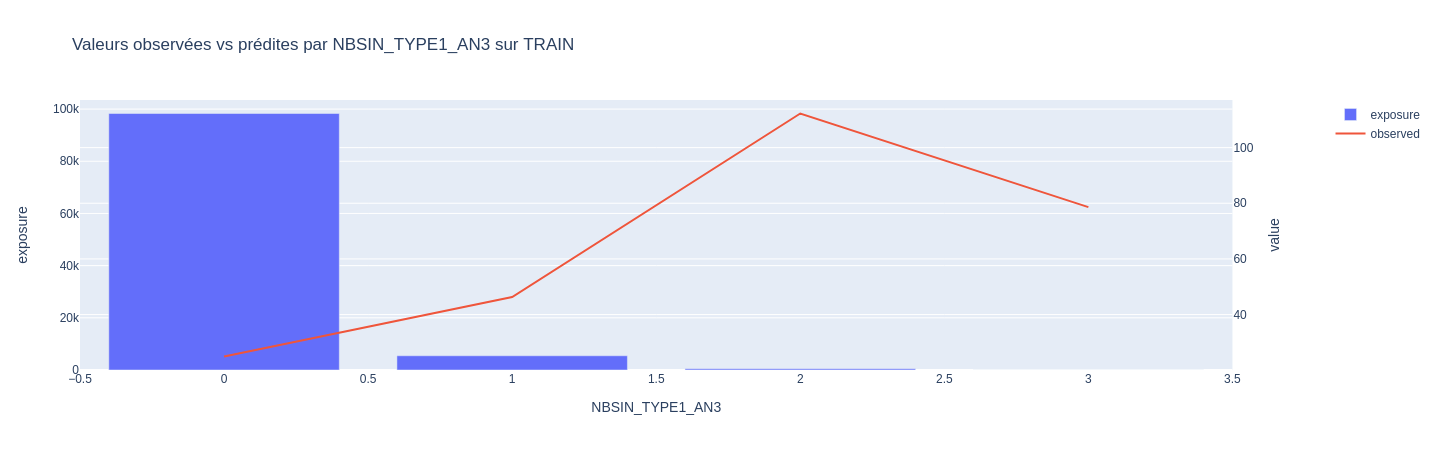

,NBSIN_TYPE1_AN3,EXPO,observed
0,0,98315.104382,24.938034
1,1,5454.470833,46.312563
2,2,455.753771,112.251654
3,3,41.575027,78.608247


In [256]:
plot_obs_pred_3(
    df=data,
    feature="NBSIN_TYPE1_AN3",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    title_train_test=titre,
    output_df=True
)

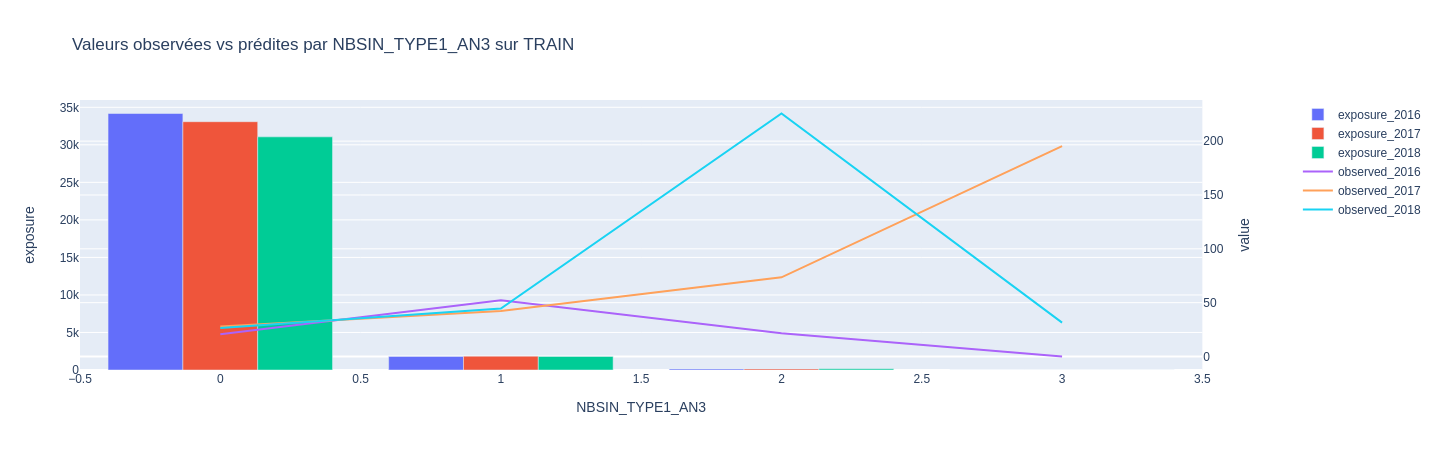

,NBSIN_TYPE1_AN3,ANNEE,EXPO,observed
0,0,2016,34173.376280,20.647806
1,0,2017,33080.080305,27.964776
2,0,2018,31061.647796,26.434628
3,1,2016,1810.767081,52.301449
4,1,2017,1843.098314,42.189968
5,1,2018,1800.605437,44.509766
6,2,2016,143.049312,21.554678
7,2,2017,147.868848,73.557907
8,2,2018,164.835611,225.672170
9,3,2016,11.257534,0.000000


In [257]:
plot_obs_pred_3(
    df=data,
    feature="NBSIN_TYPE1_AN3",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test=titre,
    output_df=True
)

**INSIGHT** : Puet être un petit effet `0` vs `1+`

#### NBSIN_TYPE2_AN1

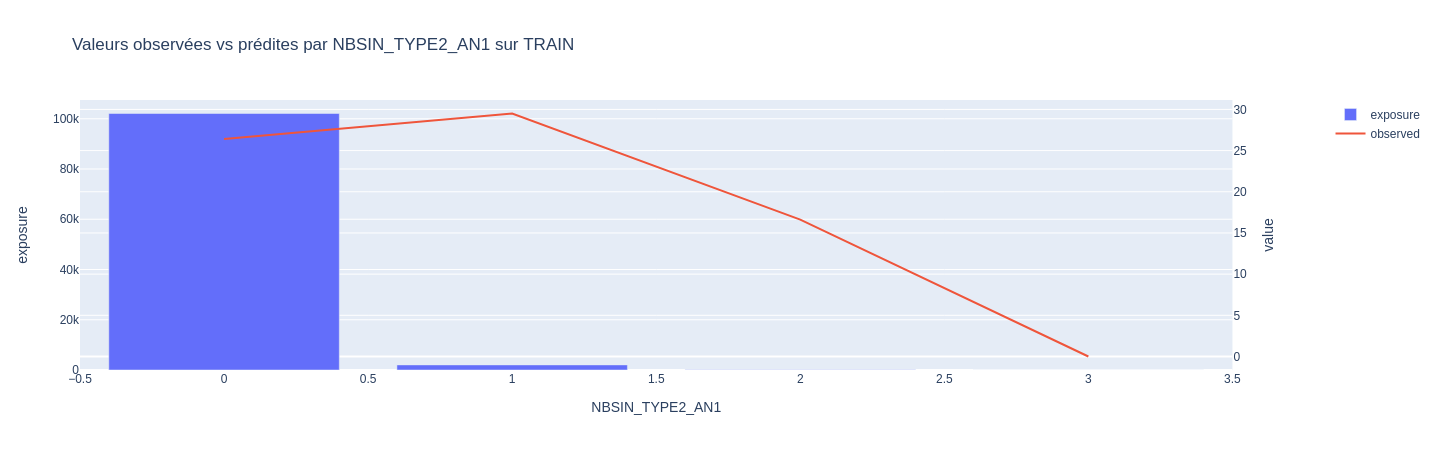

,NBSIN_TYPE2_AN1,EXPO,observed
0,0,102095.525165,26.414257
1,1,2028.784222,29.503064
2,2,131.756270,16.624361
3,3,10.838356,0.000000


In [258]:
plot_obs_pred_3(
    df=data,
    feature="NBSIN_TYPE2_AN1",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    title_train_test=titre,
    output_df=True
)

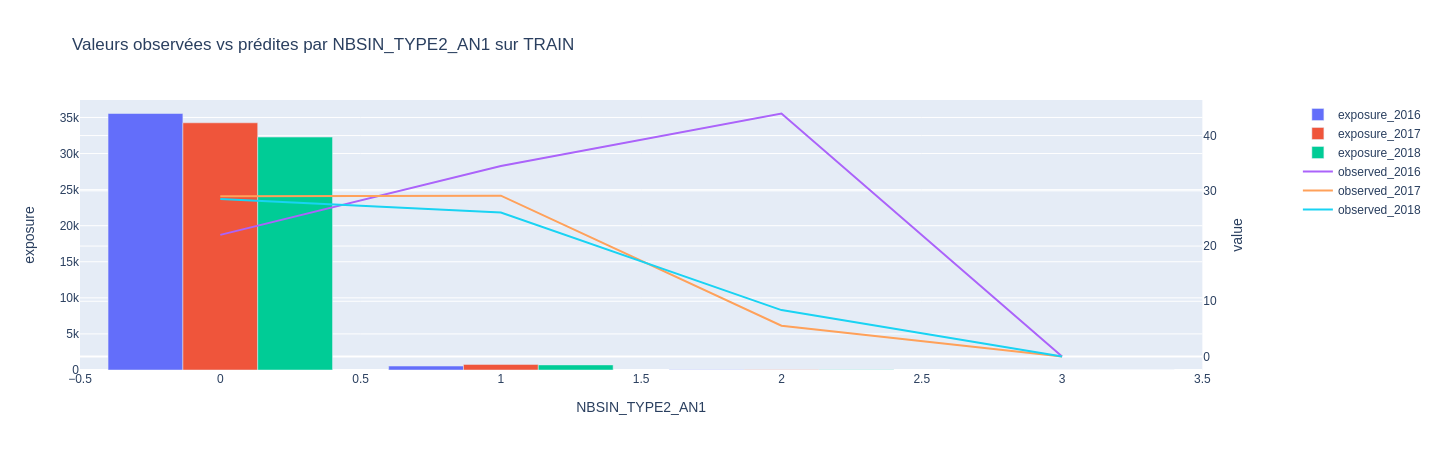

,NBSIN_TYPE2_AN1,ANNEE,EXPO,observed
0,0,2016,35551.110503,22.025199
1,0,2017,34261.470996,29.001135
2,0,2018,32282.943666,28.502222
3,1,2016,547.413680,34.478869
4,1,2017,775.732210,29.127433
5,1,2018,705.638332,26.055924
6,2,2016,34.087669,44.000662
7,2,2017,45.959015,5.567134
8,2,2018,51.709587,8.405091
9,3,2016,5.838356,0.000000


In [259]:
plot_obs_pred_3(
    df=data,
    feature="NBSIN_TYPE2_AN1",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test=titre,
    output_df=True
)

**INSIGHT** : PAS STABLE A EXCLURE

#### NBSIN_TYPE2_AN2

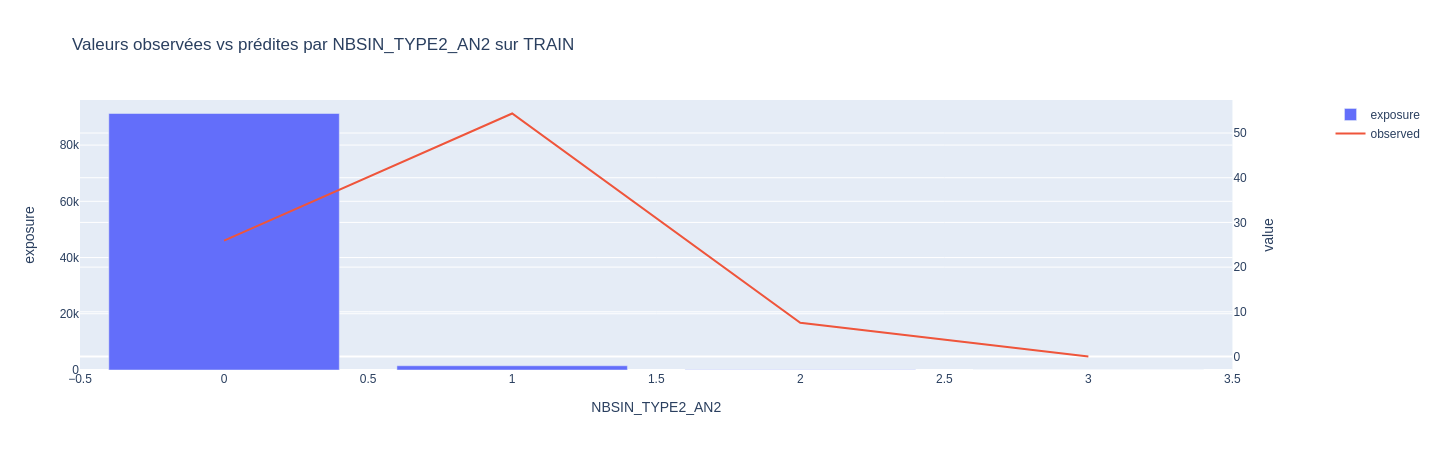

,NBSIN_TYPE2_AN2,EXPO,observed
0,0.0,91232.546877,25.925450
1,1.0,1500.392227,54.370554
2,2.0,89.421713,7.549588
3,3.0,6.000000,0.000000


In [260]:
plot_obs_pred_3(
    df=data,
    feature="NBSIN_TYPE2_AN2",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    title_train_test=titre,
    output_df=True
)

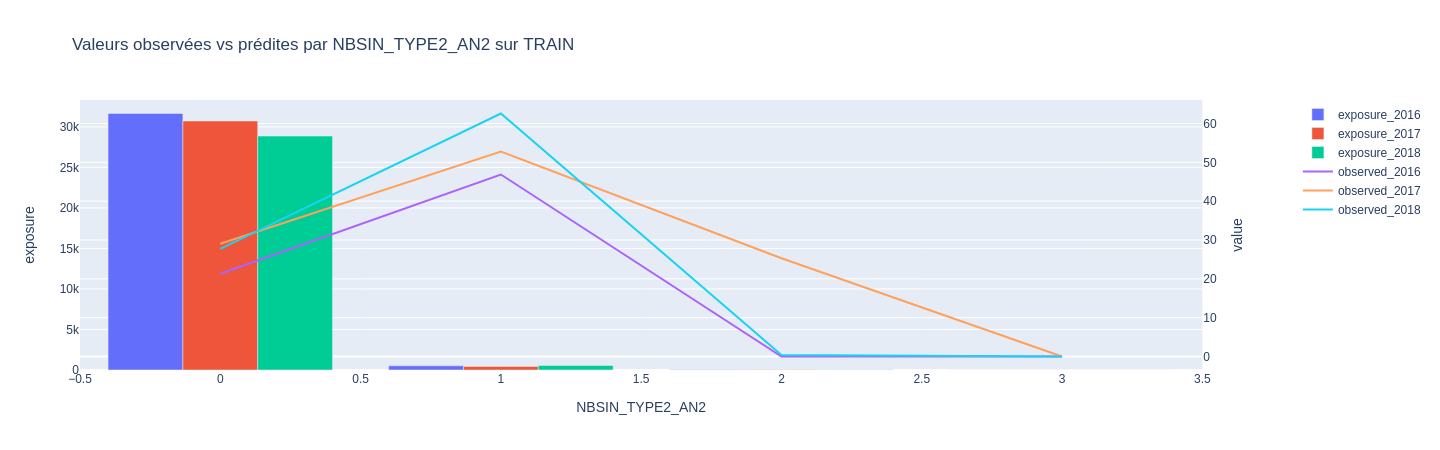

,NBSIN_TYPE2_AN2,ANNEE,EXPO,observed
0,0.0,2016,31650.757269,21.315108
1,0.0,2017,30718.741669,29.018180
2,0.0,2018,28863.047939,27.689507
3,1.0,2016,513.057522,46.864096
4,1.0,2017,432.822392,52.760787
5,1.0,2018,554.512313,62.572334
6,2.0,2016,23.912328,0.000000
7,2.0,2017,26.073770,25.305892
8,2.0,2018,39.435615,0.387394
9,3.0,2016,3.000000,0.000000


In [261]:
plot_obs_pred_3(
    df=data,
    feature="NBSIN_TYPE2_AN2",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test=titre,
    output_df=True
)

**INSIGHT** : PAS STABLE A EXCLURE

#### NBSIN_TYPE2_AN3

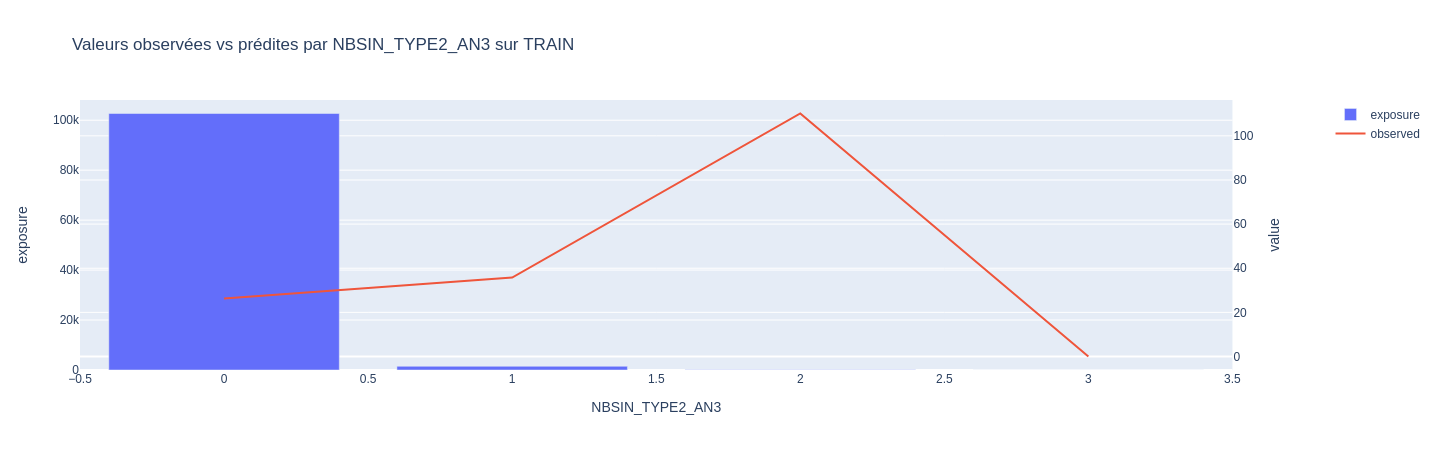

,NBSIN_TYPE2_AN3,EXPO,observed
0,0,102688.698041,26.249765
1,1,1480.662908,35.800227
2,2,93.175940,110.123609
3,3,4.367123,0.000000


In [262]:
plot_obs_pred_3(
    df=data,
    feature="NBSIN_TYPE2_AN3",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    title_train_test=titre,
    output_df=True
)

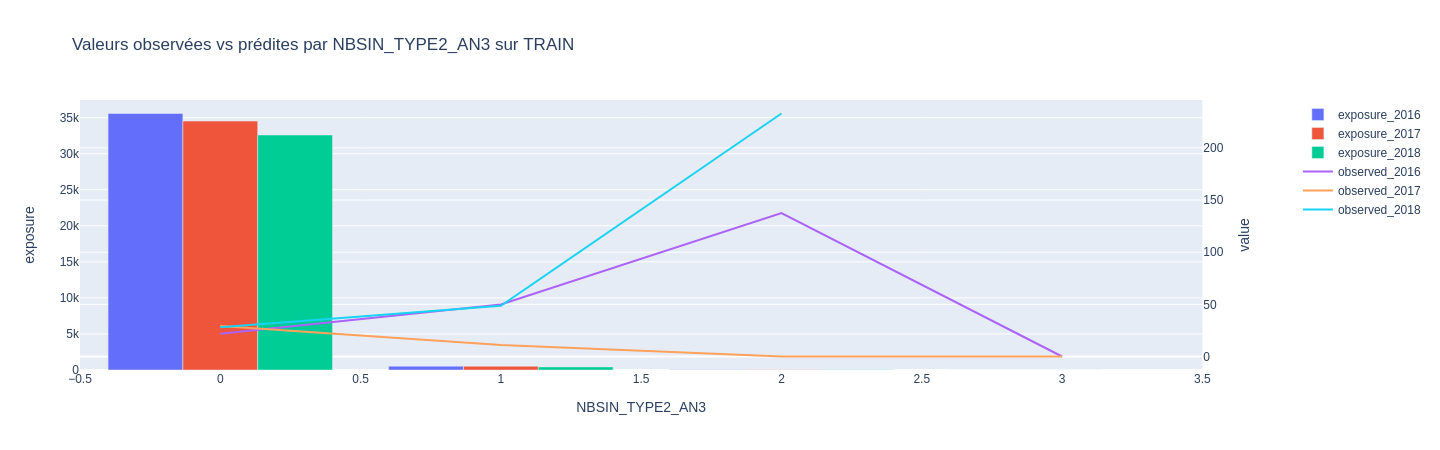

,NBSIN_TYPE2_AN3,ANNEE,EXPO,observed
0,0,2016,35573.984470,21.706581
1,0,2017,34523.356222,29.275745
2,0,2018,32591.357349,28.003365
3,1,2016,528.068478,49.970871
4,1,2017,524.024578,11.021479
5,1,2018,428.569852,48.637346
6,2,2016,35.030137,137.503317
7,2,2017,34.781420,0.000000
8,2,2018,23.364383,233.008969
9,3,2016,1.367123,0.000000


In [263]:
plot_obs_pred_3(
    df=data,
    feature="NBSIN_TYPE2_AN3",
    weight="EXPO",
    observed=field,
    use_predicted=False,
    use_year=True,
    year_field='ANNEE',
    title_train_test=titre,
    output_df=True
)

**INSIGHT** : PAS STABLE A EXCLURE